In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


fashion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


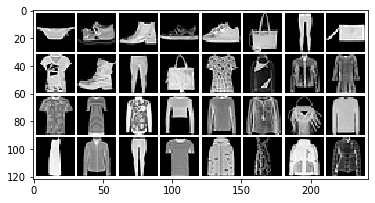

torch.Size([32, 1, 28, 28])


In [4]:
### LOAD DATA ###

dataset = 'fashion'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))

plot_grid(sample)
print(sample_magnitudes.shape)

In [5]:
def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

In [6]:
# Define Gen and Disc loss
def gen_loss(disc_gen, gen_output, x, lmd):
    reconstruction = torch.mean(torch.abs(x - gen_output))
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial + lmd * reconstruction

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [7]:
### Create new models ###

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#gen = models.ConvNet(imsize=(2, 28, 28), outsize=imsize, s=64)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

Version 0.4


In [8]:
# Set training parameters

lmd = 1e3 # loss signal

g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)

In [9]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

zm = torch.cat([torch.randn(*sample.shape).to(device), sample_magnitudes], dim=1)
gen_out = gen(zm)

xm = torch.cat([sample, sample_magnitudes], dim=1)
disc_output_real = disc(xm)
disc_output_generated = disc(torch.cat([gen_out, sample_magnitudes], dim=1))

g_loss = gen_loss(disc_output_generated, gen_out, sample, lmd)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 368.46026611328125
Discriminator initial loss: 0.6988245248794556


In [10]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)
            magnitudes = calc_mags(x)
            
            # stack magnitudes to noise / generator input
            #z = torch.randn(*x.shape).to(device)
            #z = torch.zeros(*x.shape).to(device)
            z = magnitudes.clone()
            
            zm = torch.cat([z, magnitudes], dim=1)
            
            # calc gen output
            gen.train()
            gen_output = gen(zm)
            
            # calc disc output for real and generated image
            xm = torch.cat([x, magnitudes], dim=1)
            disc.train()
            disc_output_real = disc(xm)
            disc_output_generated = disc(torch.cat([gen_output, magnitudes], dim=1))
            
            # calculate generator loss and update generator
            g_loss = gen_loss(disc_output_generated, gen(zm), x, lmd)
            history_g.append(g_loss.item())
            g_opt.zero_grad()
            g_loss.backward(retain_graph=True)
            #torch.nn.utils.clip_grad_value_(gen.parameters(), 1e-1)
            g_opt.step()
           
            # calculate discriminator loss and update discriminator
            d_loss = disc_loss(disc_output_real, disc_output_generated)
            history_d.append(d_loss.item())
            d_opt.zero_grad()
            d_loss.backward()
            #torch.nn.utils.clip_grad_value_(disc.parameters(), 1e-1)
            d_opt.step()
            
            mse_loss = torch.mean((x - gen_output) ** 2)
            history_mse.append(mse_loss.detach().cpu().item())

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history_g[-1]))
            
        plt.plot(history_g[-10000:], label="Gen loss")
        plt.plot(history_d[-10000:], label="Disc loss")
        plt.plot(history_mse[-10000:], label="MSE")
        plt.legend()
        plt.show()
        
    return history_mse

In [11]:
model_name = "zeqy"

epoch:  1 	 step:0 	 loss: 396.4
epoch:  1 	 step:100 	 loss: 130.3
epoch:  1 	 step:200 	 loss: 110.5
epoch:  1 	 step:300 	 loss: 102.9
epoch:  1 	 step:400 	 loss: 107.3
epoch:  1 	 step:500 	 loss: 88.38
epoch:  1 	 step:600 	 loss: 94.48
epoch:  1 	 step:700 	 loss: 83.67
epoch:  1 	 step:800 	 loss: 80.12
epoch:  1 	 step:900 	 loss: 91.75
epoch:  1 	 step:1000 	 loss: 81.15
epoch:  1 	 step:1100 	 loss: 94.25
epoch:  1 	 step:1200 	 loss: 76.1
epoch:  1 	 step:1300 	 loss: 85.59
epoch:  1 	 step:1400 	 loss: 83.7
epoch:  1 	 step:1500 	 loss: 75.11
epoch:  1 	 step:1600 	 loss: 84.53
epoch:  1 	 step:1700 	 loss: 79.68
epoch:  1 	 step:1800 	 loss: 72.92


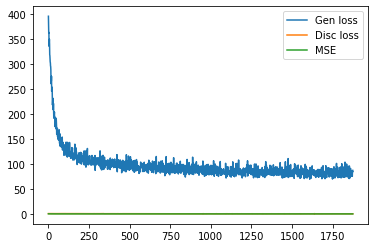

epoch:  2 	 step:0 	 loss: 83.81
epoch:  2 	 step:100 	 loss: 84.44
epoch:  2 	 step:200 	 loss: 71.07
epoch:  2 	 step:300 	 loss: 89.0
epoch:  2 	 step:400 	 loss: 74.44
epoch:  2 	 step:500 	 loss: 83.44
epoch:  2 	 step:600 	 loss: 78.38
epoch:  2 	 step:700 	 loss: 82.98
epoch:  2 	 step:800 	 loss: 73.15
epoch:  2 	 step:900 	 loss: 84.38
epoch:  2 	 step:1000 	 loss: 70.83
epoch:  2 	 step:1100 	 loss: 76.91
epoch:  2 	 step:1200 	 loss: 78.2
epoch:  2 	 step:1300 	 loss: 78.92
epoch:  2 	 step:1400 	 loss: 70.59
epoch:  2 	 step:1500 	 loss: 68.77
epoch:  2 	 step:1600 	 loss: 70.85
epoch:  2 	 step:1700 	 loss: 73.95
epoch:  2 	 step:1800 	 loss: 79.33


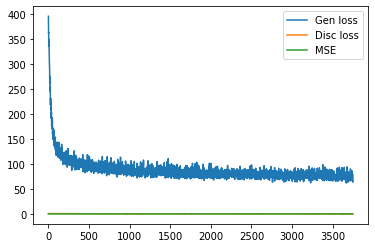

epoch:  3 	 step:0 	 loss: 75.79
epoch:  3 	 step:100 	 loss: 70.62
epoch:  3 	 step:200 	 loss: 81.22
epoch:  3 	 step:300 	 loss: 82.68
epoch:  3 	 step:400 	 loss: 74.64
epoch:  3 	 step:500 	 loss: 72.16
epoch:  3 	 step:600 	 loss: 73.06
epoch:  3 	 step:700 	 loss: 83.4
epoch:  3 	 step:800 	 loss: 64.83
epoch:  3 	 step:900 	 loss: 72.24
epoch:  3 	 step:1000 	 loss: 72.12
epoch:  3 	 step:1100 	 loss: 66.0
epoch:  3 	 step:1200 	 loss: 62.84
epoch:  3 	 step:1300 	 loss: 74.63
epoch:  3 	 step:1400 	 loss: 71.14
epoch:  3 	 step:1500 	 loss: 73.17
epoch:  3 	 step:1600 	 loss: 77.96
epoch:  3 	 step:1700 	 loss: 70.9
epoch:  3 	 step:1800 	 loss: 79.63


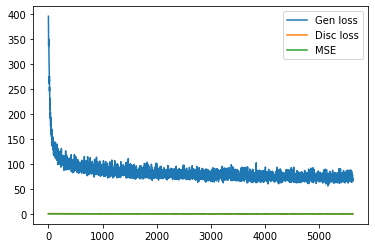

epoch:  4 	 step:0 	 loss: 59.93
epoch:  4 	 step:100 	 loss: 75.58
epoch:  4 	 step:200 	 loss: 70.23
epoch:  4 	 step:300 	 loss: 75.44
epoch:  4 	 step:400 	 loss: 77.98
epoch:  4 	 step:500 	 loss: 75.6
epoch:  4 	 step:600 	 loss: 66.06
epoch:  4 	 step:700 	 loss: 69.98
epoch:  4 	 step:800 	 loss: 67.27
epoch:  4 	 step:900 	 loss: 72.23
epoch:  4 	 step:1000 	 loss: 68.5
epoch:  4 	 step:1100 	 loss: 69.54
epoch:  4 	 step:1200 	 loss: 67.3
epoch:  4 	 step:1300 	 loss: 79.53
epoch:  4 	 step:1400 	 loss: 66.56
epoch:  4 	 step:1500 	 loss: 68.33
epoch:  4 	 step:1600 	 loss: 65.27
epoch:  4 	 step:1700 	 loss: 74.81
epoch:  4 	 step:1800 	 loss: 79.54


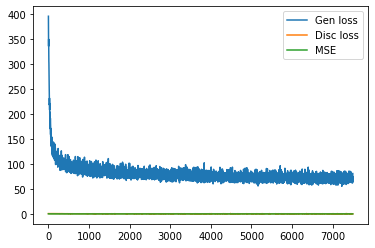

epoch:  5 	 step:0 	 loss: 65.24
epoch:  5 	 step:100 	 loss: 68.53
epoch:  5 	 step:200 	 loss: 83.92
epoch:  5 	 step:300 	 loss: 74.5
epoch:  5 	 step:400 	 loss: 70.26
epoch:  5 	 step:500 	 loss: 64.45
epoch:  5 	 step:600 	 loss: 72.9
epoch:  5 	 step:700 	 loss: 67.72
epoch:  5 	 step:800 	 loss: 63.9
epoch:  5 	 step:900 	 loss: 69.85
epoch:  5 	 step:1000 	 loss: 71.26
epoch:  5 	 step:1100 	 loss: 73.61
epoch:  5 	 step:1200 	 loss: 70.67
epoch:  5 	 step:1300 	 loss: 59.72
epoch:  5 	 step:1400 	 loss: 82.48
epoch:  5 	 step:1500 	 loss: 75.42
epoch:  5 	 step:1600 	 loss: 72.14
epoch:  5 	 step:1700 	 loss: 63.63
epoch:  5 	 step:1800 	 loss: 62.93


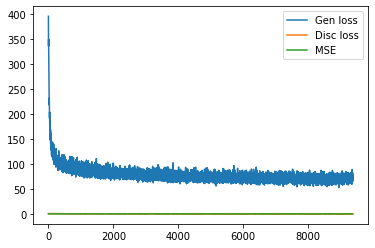

epoch:  6 	 step:0 	 loss: 78.04
epoch:  6 	 step:100 	 loss: 71.28
epoch:  6 	 step:200 	 loss: 70.17
epoch:  6 	 step:300 	 loss: 66.44
epoch:  6 	 step:400 	 loss: 67.54
epoch:  6 	 step:500 	 loss: 64.59
epoch:  6 	 step:600 	 loss: 70.38
epoch:  6 	 step:700 	 loss: 71.26
epoch:  6 	 step:800 	 loss: 71.09
epoch:  6 	 step:900 	 loss: 70.88
epoch:  6 	 step:1000 	 loss: 78.51
epoch:  6 	 step:1100 	 loss: 65.87
epoch:  6 	 step:1200 	 loss: 71.21
epoch:  6 	 step:1300 	 loss: 66.4
epoch:  6 	 step:1400 	 loss: 61.47
epoch:  6 	 step:1500 	 loss: 70.51
epoch:  6 	 step:1600 	 loss: 65.89
epoch:  6 	 step:1700 	 loss: 76.92
epoch:  6 	 step:1800 	 loss: 65.43


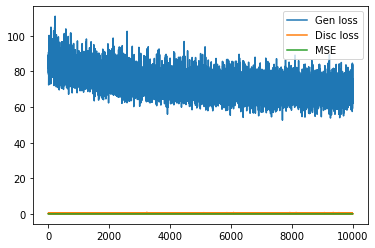

epoch:  7 	 step:0 	 loss: 65.98
epoch:  7 	 step:100 	 loss: 64.19
epoch:  7 	 step:200 	 loss: 62.94
epoch:  7 	 step:300 	 loss: 68.69
epoch:  7 	 step:400 	 loss: 68.87
epoch:  7 	 step:500 	 loss: 66.92
epoch:  7 	 step:600 	 loss: 63.33
epoch:  7 	 step:700 	 loss: 72.86
epoch:  7 	 step:800 	 loss: 67.69
epoch:  7 	 step:900 	 loss: 64.62
epoch:  7 	 step:1000 	 loss: 64.82
epoch:  7 	 step:1100 	 loss: 62.55
epoch:  7 	 step:1200 	 loss: 71.58
epoch:  7 	 step:1300 	 loss: 61.54
epoch:  7 	 step:1400 	 loss: 76.39
epoch:  7 	 step:1500 	 loss: 76.07
epoch:  7 	 step:1600 	 loss: 70.22
epoch:  7 	 step:1700 	 loss: 66.62
epoch:  7 	 step:1800 	 loss: 67.24


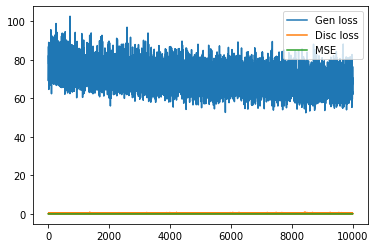

epoch:  8 	 step:0 	 loss: 66.06
epoch:  8 	 step:100 	 loss: 64.58
epoch:  8 	 step:200 	 loss: 65.07
epoch:  8 	 step:300 	 loss: 60.64
epoch:  8 	 step:400 	 loss: 63.56
epoch:  8 	 step:500 	 loss: 69.17
epoch:  8 	 step:600 	 loss: 75.42
epoch:  8 	 step:700 	 loss: 70.99
epoch:  8 	 step:800 	 loss: 67.01
epoch:  8 	 step:900 	 loss: 64.04
epoch:  8 	 step:1000 	 loss: 67.15
epoch:  8 	 step:1100 	 loss: 62.93
epoch:  8 	 step:1200 	 loss: 60.55
epoch:  8 	 step:1300 	 loss: 65.78
epoch:  8 	 step:1400 	 loss: 69.29
epoch:  8 	 step:1500 	 loss: 61.38
epoch:  8 	 step:1600 	 loss: 63.01
epoch:  8 	 step:1700 	 loss: 62.64
epoch:  8 	 step:1800 	 loss: 63.28


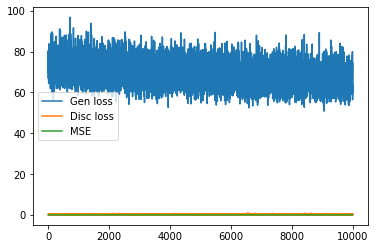

epoch:  9 	 step:0 	 loss: 62.67
epoch:  9 	 step:100 	 loss: 58.65
epoch:  9 	 step:200 	 loss: 68.6
epoch:  9 	 step:300 	 loss: 58.43
epoch:  9 	 step:400 	 loss: 59.0
epoch:  9 	 step:500 	 loss: 62.11
epoch:  9 	 step:600 	 loss: 68.1
epoch:  9 	 step:700 	 loss: 67.43
epoch:  9 	 step:800 	 loss: 65.05
epoch:  9 	 step:900 	 loss: 62.65
epoch:  9 	 step:1000 	 loss: 62.91
epoch:  9 	 step:1100 	 loss: 74.94
epoch:  9 	 step:1200 	 loss: 63.1
epoch:  9 	 step:1300 	 loss: 73.6
epoch:  9 	 step:1400 	 loss: 66.35
epoch:  9 	 step:1500 	 loss: 62.42
epoch:  9 	 step:1600 	 loss: 63.21
epoch:  9 	 step:1700 	 loss: 66.75
epoch:  9 	 step:1800 	 loss: 55.67


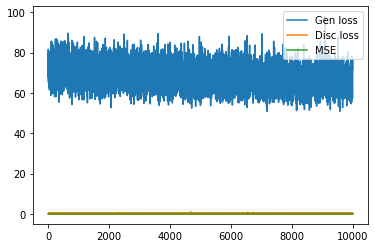

epoch: 10 	 step:0 	 loss: 62.76
epoch: 10 	 step:100 	 loss: 67.79
epoch: 10 	 step:200 	 loss: 62.22
epoch: 10 	 step:300 	 loss: 62.55
epoch: 10 	 step:400 	 loss: 65.87
epoch: 10 	 step:500 	 loss: 66.28
epoch: 10 	 step:600 	 loss: 57.85
epoch: 10 	 step:700 	 loss: 65.42
epoch: 10 	 step:800 	 loss: 64.34
epoch: 10 	 step:900 	 loss: 65.07
epoch: 10 	 step:1000 	 loss: 67.22
epoch: 10 	 step:1100 	 loss: 69.84
epoch: 10 	 step:1200 	 loss: 60.45
epoch: 10 	 step:1300 	 loss: 73.05
epoch: 10 	 step:1400 	 loss: 61.17
epoch: 10 	 step:1500 	 loss: 66.83
epoch: 10 	 step:1600 	 loss: 73.3
epoch: 10 	 step:1700 	 loss: 60.49
epoch: 10 	 step:1800 	 loss: 65.29


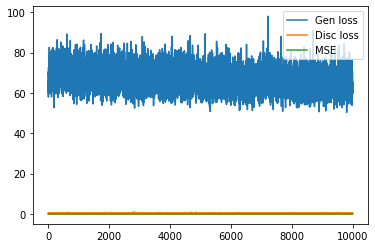

epoch: 11 	 step:0 	 loss: 60.35
epoch: 11 	 step:100 	 loss: 55.16
epoch: 11 	 step:200 	 loss: 63.55
epoch: 11 	 step:300 	 loss: 61.72
epoch: 11 	 step:400 	 loss: 65.84
epoch: 11 	 step:500 	 loss: 63.24
epoch: 11 	 step:600 	 loss: 60.55
epoch: 11 	 step:700 	 loss: 64.91
epoch: 11 	 step:800 	 loss: 64.17
epoch: 11 	 step:900 	 loss: 58.79
epoch: 11 	 step:1000 	 loss: 57.61
epoch: 11 	 step:1100 	 loss: 59.61
epoch: 11 	 step:1200 	 loss: 60.19
epoch: 11 	 step:1300 	 loss: 58.74
epoch: 11 	 step:1400 	 loss: 61.27
epoch: 11 	 step:1500 	 loss: 66.59
epoch: 11 	 step:1600 	 loss: 70.99
epoch: 11 	 step:1700 	 loss: 63.84
epoch: 11 	 step:1800 	 loss: 53.69


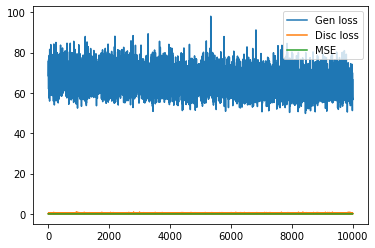

epoch: 12 	 step:0 	 loss: 55.66
epoch: 12 	 step:100 	 loss: 64.95
epoch: 12 	 step:200 	 loss: 54.91
epoch: 12 	 step:300 	 loss: 68.11
epoch: 12 	 step:400 	 loss: 63.82
epoch: 12 	 step:500 	 loss: 73.67
epoch: 12 	 step:600 	 loss: 67.1
epoch: 12 	 step:700 	 loss: 66.57
epoch: 12 	 step:800 	 loss: 66.0
epoch: 12 	 step:900 	 loss: 70.4
epoch: 12 	 step:1000 	 loss: 67.01
epoch: 12 	 step:1100 	 loss: 61.31
epoch: 12 	 step:1200 	 loss: 67.15
epoch: 12 	 step:1300 	 loss: 69.86
epoch: 12 	 step:1400 	 loss: 63.02
epoch: 12 	 step:1500 	 loss: 65.04
epoch: 12 	 step:1600 	 loss: 67.87
epoch: 12 	 step:1700 	 loss: 66.96
epoch: 12 	 step:1800 	 loss: 62.2


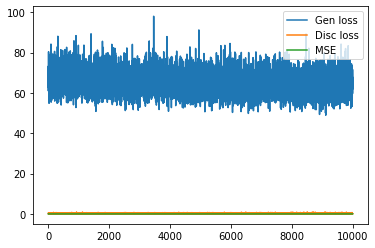

epoch: 13 	 step:0 	 loss: 62.9
epoch: 13 	 step:100 	 loss: 63.6
epoch: 13 	 step:200 	 loss: 60.48
epoch: 13 	 step:300 	 loss: 57.31
epoch: 13 	 step:400 	 loss: 64.59
epoch: 13 	 step:500 	 loss: 57.02
epoch: 13 	 step:600 	 loss: 62.37
epoch: 13 	 step:700 	 loss: 62.29
epoch: 13 	 step:800 	 loss: 65.39


In [ ]:
### TRAIN MODEL ###

import time
num_epochs = 100

train_model(gen, disc, g_opt, d_opt, device, dataloader['train'], epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/models/cGAN_Fashion/FCGenerator2048Fashion_{}.sd".format(model_name))
torch.save(disc_weights, "../cache/models/cGAN_Fashion/ConvDiscriminator64Fashion_{}.sd".format(model_name))

In [ ]:
### LOAD MODEL ####

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#gen = models.ConvNet(imsize=(2, 28, 28), outsize=imsize, s=64)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
#disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/cGAN_Fashion/FCGenerator2048Fashion_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));
#disc.load_state_dict(torch.load("../cache/models/cGAN_Fashion/ConvDiscriminator64Fashion_{}.sd".format(model_name), map_location={'cuda:1': device.__str__()}));

In [18]:
def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        magn = calc_mags(data)
        
        #z = torch.randn(*data.shape).to(device)
        #z = torch.zeros(*data.shape).to(device)
        z = magn.clone()
        
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [19]:
# Calculate test predictions #

test_predicted, test_original = test_generator(gen, device, dataloader['test'])
print(test_predicted.shape)

(8000, 1, 28, 28)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


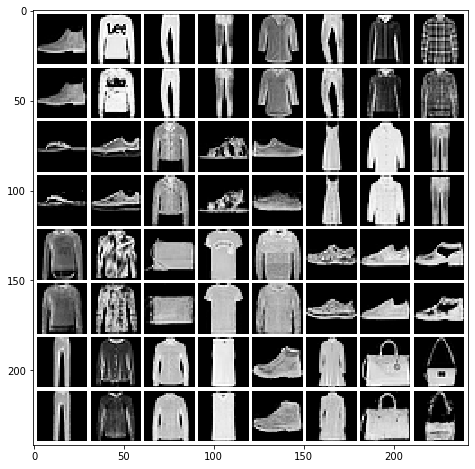

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


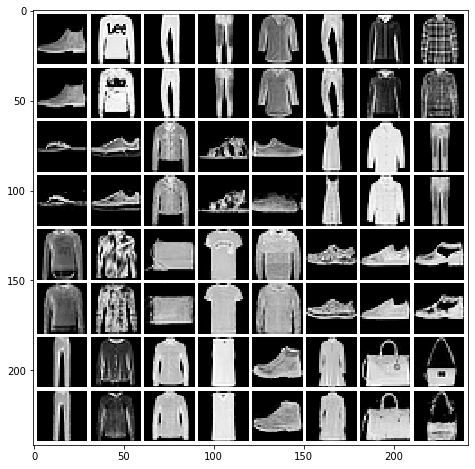

In [20]:
# Print test predictions 2 #
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/end-to-end/signal-prediction/cgan-" + model_name + ".png")

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/Fashion/end-to-end/signal-prediction/cgan-" + model_name + "-reg.png")

In [21]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.017514020546059328, std: 0.016942522829549903
  MAE: 0.060258891257944924, std: 0.03359421857997982
  SSIM: 0.7587973807067674, std: 0.16595649685521513
  Sharpness: 0.11392498628971476, std: 0.05629767410817906
  PhCo-MSE: 0.017382213438168037, std: 0.0209573326543691
  PhCo-MAE: 0.06043336160018953, std: 0.04003243983786332
  PhCo-SSIM: 0.7626709078925039, std: 0.1796886980594594
  CroCo-MSE: 0.01489660524748615, std: 0.01332605555797432
  CroCo-MAE: 0.05652927641403949, std: 0.030039297423213693
  CroCo-SSIM: 0.7783518578861441, std: 0.15024098350887227

Magnitude error:
  MSE Magnitude: 3.412151886904845, std: 3.1396747656561668

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01751 | 0.06026 | 0.7588 | 0.1139 | 0.01738 | 0.06043 | 0.7627 | 0.01490 | 0.05653 | 0.7784 | 3.412 |


## Evaluation for different cGAN models (random z and 1024 samples)

| Nr | Type | Loss | Size | epochs | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| zeroz | z=0 |  log GAN + 1e3 * MAE | 2048 + 64 | 100 | 0.01767 | 0.06078 | 0.7565 | 0.1144 | 0.01764 | 0.06094 | 0.7620 | 0.01502 | 0.05698 | 0.7775 | 3.424 |
| zeqy | z=y |  log GAN + 1e3 * MAE | 2048 + 64 | 100 | 0.01751 | 0.06026 | 0.7588 | 0.1139 | 0.01738 | 0.06043 | 0.7627 | 0.01490 | 0.05653 | 0.7784 | 3.412 |
| randz | z=randn |  log GAN + 1e3 * MAE | 2048 + 64 | 100 | 0.01779 | 0.06080 | 0.7561 | 0.1144 | 0.01767 | 0.06087 | 0.7610 | 0.01499 | 0.05686 | 0.7777 | 3.381 |
| 4 | no z |  log GAN + 1e3 * MAE | 2048 + 64 | 100 |

---

Signal error:
  MSE: 0.01767030932353464, std: 0.016888340185844324
  MAE: 0.06077942343290488, std: 0.0339969733158891
  SSIM: 0.7565225388207938, std: 0.16726110268718875
  Sharpness: 0.11443308385180646, std: 0.057089749616798906
  PhCo-MSE: 0.017635622298371345, std: 0.023743724709908126
  PhCo-MAE: 0.06094056874826492, std: 0.04285827729325107
  PhCo-SSIM: 0.762002612438881, std: 0.17834415511086224
  CroCo-MSE: 0.015024712742729207, std: 0.01365848086305225
  CroCo-MAE: 0.05698258622578578, std: 0.030807123344059342
  CroCo-SSIM: 0.7775385423775694, std: 0.15138346118450588

Magnitude error:
  MSE Magnitude: 3.4235086760999685, std: 3.207437638911659

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


---

Signal error:
  MSE: 0.017514020546059328, std: 0.016942522829549903
  MAE: 0.060258891257944924, std: 0.03359421857997982
  SSIM: 0.7587973807067674, std: 0.16595649685521513
  Sharpness: 0.11392498628971476, std: 0.05629767410817906
  PhCo-MSE: 0.017382213438168037, std: 0.0209573326543691
  PhCo-MAE: 0.06043336160018953, std: 0.04003243983786332
  PhCo-SSIM: 0.7626709078925039, std: 0.1796886980594594
  CroCo-MSE: 0.01489660524748615, std: 0.01332605555797432
  CroCo-MAE: 0.05652927641403949, std: 0.030039297423213693
  CroCo-SSIM: 0.7783518578861441, std: 0.15024098350887227

Magnitude error:
  MSE Magnitude: 3.412151886904845, std: 3.1396747656561668

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

---

Signal error:
  MSE: 0.01779046284548258, std: 0.016872721048784005
  MAE: 0.06079740791756194, std: 0.033476284589556676
  SSIM: 0.7561202966453822, std: 0.16569591802376668
  Sharpness: 0.11437977468240534, std: 0.05566890062128635
  PhCo-MSE: 0.01766905605438751, std: 0.022146451431166333
  PhCo-MAE: 0.06087195801046619, std: 0.04068803261796508
  PhCo-SSIM: 0.7609932249703424, std: 0.17931556202997595
  CroCo-MSE: 0.014992063732165661, std: 0.013368030879365644
  CroCo-MAE: 0.05685567679574888, std: 0.03014576582803696
  CroCo-SSIM: 0.7777312464186072, std: 0.1492147862670335

Magnitude error:
  MSE Magnitude: 3.38074352499775, std: 2.9555004608883912

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

---